Import essential python packages

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import osmnx as ox
import pandas as pd
import time
from shapely.geometry import Polygon

Set options

In [2]:
%matplotlib inline
pd.set_option('display.max_columns', None)
print("osmnx version:", ox.__version__)

osmnx version: 1.1.1


Supporting Function Definition

In [4]:
#
# Source: https://github.com/cyang-kth/fmm/blob/master/example/osmnx_example/download_network.ipynb
#
# Issue:      Below function has some issues when converting graph, G, to 
#             GeoPandas's GeoDataFrame to get a list of GeoDataFrame nodes and edges.
# Workaround: Comment out function call as it is not necessary at the moment.
# Result:     Graph containing road network of Porto city is downloaded successfully
#             without calling that function.
def save_graph_shapefile_directional(G, filepath = None, encoding = "utf-8"):
    # default filepath if none was provided
    if filepath is None:
        filepath = os.path.join(ox.settings.data_folder, "graph_shapefile")

    # if save folder does not already exist, create it (shapefiles
    # get saved as set of files)
    if not filepath == "" and not os.path.exists(filepath):
        os.makedirs(filepath)
        
    filepath_nodes = os.path.join(filepath, "nodes.shp")
    filepath_edges = os.path.join(filepath, "edges.shp")

    # convert undirected graph to gdfs and stringify non-numeric columns
    gdf_nodes, gdf_edges = ox.utils_graph.graph_to_gdfs(G)
    gdf_nodes            = ox.io._stringify_nonnumeric_cols(gdf_nodes)
    gdf_edges            = ox.io._stringify_nonnumeric_cols(gdf_edges)
    
    # We need an unique ID for each edge
    gdf_edges["fid"] = gdf_edges.index
    
    # save the nodes and edges as separate ESRI shapefiles
    gdf_nodes.to_file(filepath_nodes, encoding = encoding)
    gdf_edges.to_file(filepath_edges, encoding = encoding)

In [4]:
def getMinMax(xMax, yMax, xMin, yMin, bFirst, xLong, yLat):
    # return the min, max of x, y coord
    
    if bFirst:
        xMin = xMax = xLong
        yMin = yMax = yLat
        bFirst      = False
    else:
        if xLong > xMin:
            xMin = xLong
        elif xLong < xMax:
            xMax = xLong

        if yLat < yMin:
            yMin = yLat
        elif yLat > yMax:
            yMax = yLat
                    
    return xMax, yMax, xMin, yMin, bFirst

Import the first 1000 trips from the unzipped train.csv

In [5]:
# import 1000 taxi trajectory dataset
dfTaxiTraj = pd.read_csv('./data/train.csv', nrows = 1000)
dfTaxiTraj = pd.DataFrame(dfTaxiTraj)

#### Task 2: - Plot first 10 taxi's trips (GPS points) onto road network map of Porto

Convert 1000 trips into GPS points

In [6]:
# series containing 1000 trajectory
# extract min, max for extracting coords of the map
trajList    = []
count       = 0
xMax = yMax = 0
xMin = yMin = 0
bFirst      = True

for item in dfTaxiTraj['POLYLINE']:
    item = item[2: -2]
    traj = []
    
    if len(item) <= 2:
        print('Skip empty row:', count, ', len:', len(item), ', element:', item)
    else:
        for elem in item.split('],['):
            elem        = elem.strip()
            xLong, yLat = elem.split(',')
            traj.append((float(xLong), float(yLat)))
            
            xMax, yMax, xMin, yMin, bFirst = getMinMax(xMax, yMax, xMin, yMin, bFirst, xLong, yLat)
        
    trajList.append(traj)
    count += 1
    
print('xMin:', xMin, ', yMin:', yMin, ', xMax:', xMax, ', yMax:', yMax)

Skip empty row: 762 , len: 0 , element: 
xMin: -8.709399 , yMin: 41.008275 , xMax: -8.486757 , yMax: 41.260086


Extract 10 trips from the 1000 trajectories into GPS points

In [7]:
# extract 10 trajectories from the list of 1000 trajectories
limit       = 10
coords      = []
xMax = yMax = 0
xMin = yMin = 0
bFirst      = True

for i in range(limit):
    tmpTraj = trajList[i]
    x       = []
    y       = []
    
    for tmpCord in tmpTraj:
        tmpX = tmpCord[0]
        tmpY = tmpCord[1]
        x.append(tmpX)
        y.append(tmpY)

        xMax, yMax, xMin, yMin, bFirst = getMinMax(xMax, yMax, xMin, yMin, bFirst, tmpX, tmpY)
            
    coords.append((x, y))
    
print('xMin:', xMin, ', yMin:', yMin, ', xMax:', xMax, ', yMax:', yMax)

xMin: -8.57466 , yMin: 41.134158 , xMax: -8.689086 , yMax: 41.180517


Download Portugal Porto's road network using a bounding box

In [8]:
startTime       = time.time()
delta           = 0.01
bounds          = (xMax - delta / 2, xMin + delta / 2, yMin - delta * 0.7, yMax + delta * 0.7)
x1, x2, y1, y2  = bounds
boundaryPolygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)])
G               = ox.graph_from_polygon(boundaryPolygon, network_type = 'drive')
print("--- %s seconds ---" % (time.time() - startTime))

C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


--- 20.432357788085938 seconds ---


Plot 10 trips onto the road network

   Duration 4.769885301589966 seconds


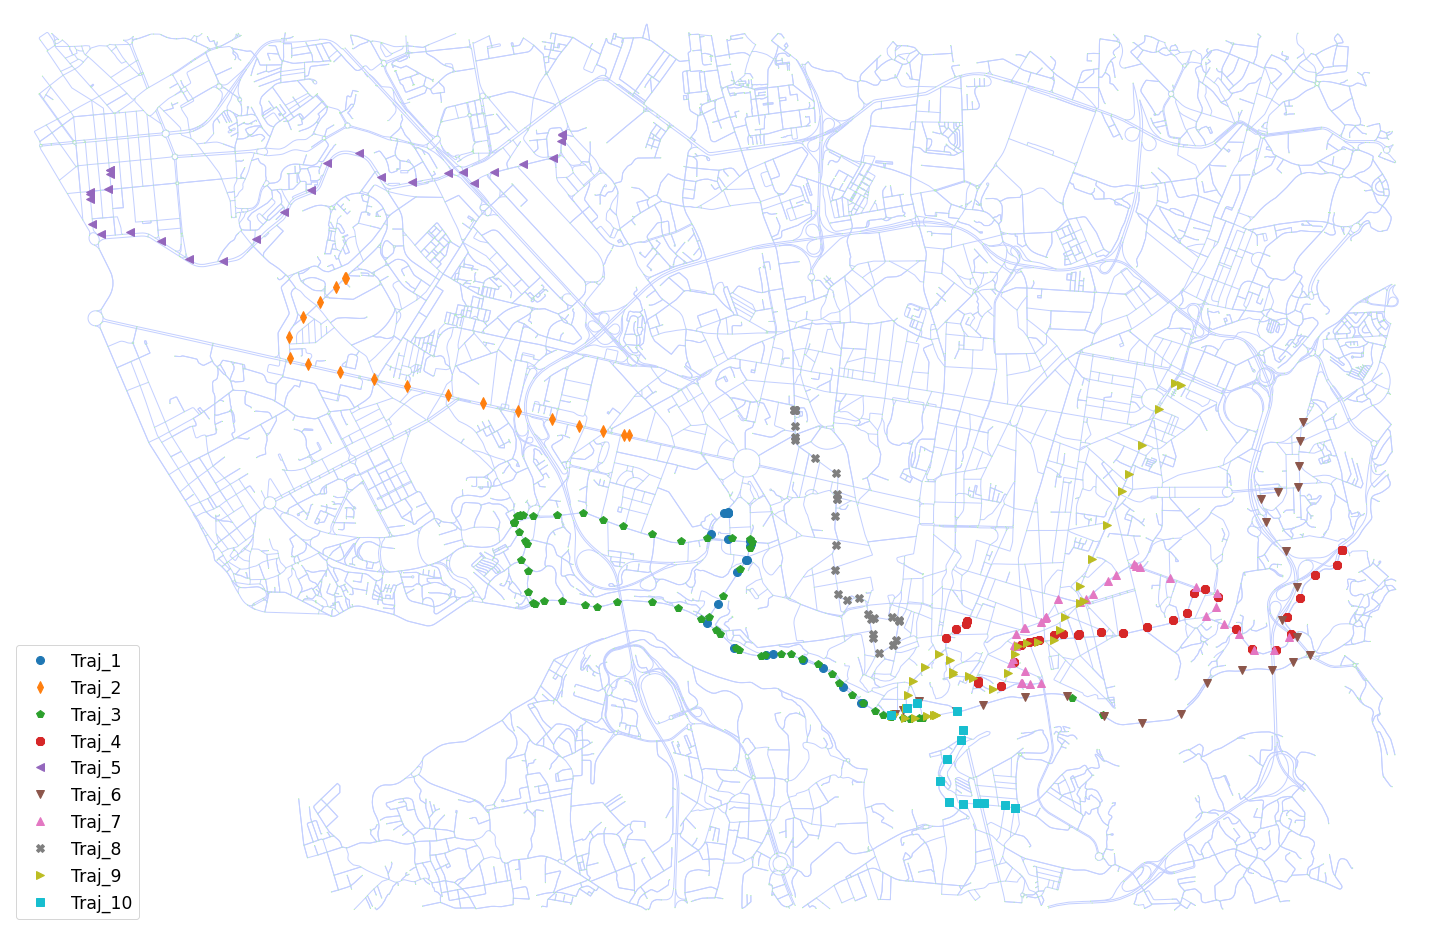

In [29]:
# plot graph using bounding box method
startTime = time.time()
marker    = ['o', 'd', 'p', '8', '<', 'v', '^', 'X', '>', 's']
fig, ax   = ox.plot_graph(G, figsize = (20, 20), bgcolor = '#FFFFFF', \
                          node_color = '#ACFF97', node_size = 1, \
                          edge_color = '#C4D0FF', show = False, close = False)

for i in range(len(coords)):
    ax.plot(coords[i][0], coords[i][1], marker[i], ms = 8, label = 'Traj_{}'.format(i + 1))

plt.legend(fontsize = 'xx-large')
plt.tight_layout()
print("   Duration %s seconds" % (time.time() - startTime))

Detailed GPS plots for Trajectory 1

In [40]:
# extract 10 trajectories from the list of 1000 trajectories
xMax = yMax = 0
xMin = yMin = 0
bFirst      = True
i           = 0
tmpTraj = trajList[i]

for tmpCord in tmpTraj:
    tmpX = tmpCord[0]
    tmpY = tmpCord[1]
    xMax, yMax, xMin, yMin, bFirst = getMinMax(xMax, yMax, xMin, yMin, bFirst, tmpX, tmpY)

print('xMin:', xMin, ', yMin:', yMin, ', xMax:', xMax, ', yMax:', yMax)

xMin: -8.618499 , yMin: 41.141376 , xMax: -8.632746 , yMax: 41.154516


In [41]:
startTime       = time.time()
delta           = 0.01
bounds          = (xMax - delta / 2, xMin + delta / 2, yMin - delta * 0.7, yMax + delta * 0.7)
x1, x2, y1, y2  = bounds
boundaryPolygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)])
G               = ox.graph_from_polygon(boundaryPolygon, network_type = 'drive')
print("--- %s seconds ---" % (time.time() - startTime))

C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


--- 2.702937126159668 seconds ---


C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


   Duration 0.39724302291870117 seconds


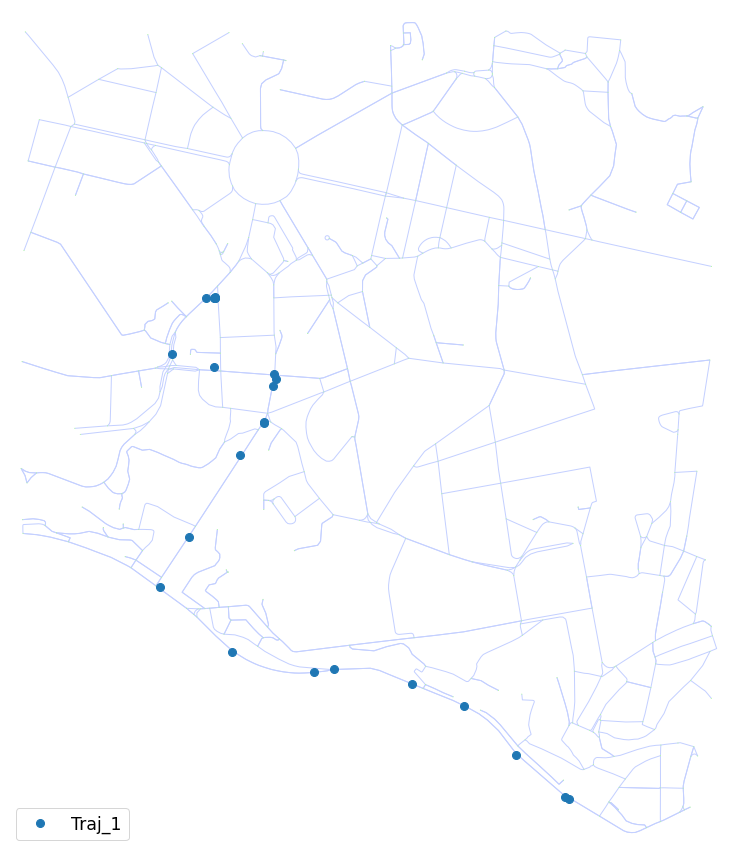

In [43]:
# plot graph using bounding box method
startTime = time.time()
marker    = ['o', 'd', 'p', '8', '<', 'v', '^', 'X', '>', 's']
fig, ax   = ox.plot_graph(G, figsize = (10, 10), bgcolor = '#FFFFFF', \
                          node_color = '#ACFF97', node_size = 1, \
                          edge_color = '#C4D0FF', show = False, close = False)

ax.plot(coords[i][0], coords[i][1], marker[i], ms = 8, label = 'Traj_{}'.format(i + 1))

plt.legend(fontsize = 'xx-large')
plt.tight_layout()
print("   Duration %s seconds" % (time.time() - startTime))

Detailed GPS plots for Trajectory 2

In [44]:
# extract 10 trajectories from the list of 1000 trajectories
xMax = yMax = 0
xMin = yMin = 0
bFirst      = True
i           = 1
tmpTraj = trajList[i]

for tmpCord in tmpTraj:
    tmpX = tmpCord[0]
    tmpY = tmpCord[1]
    xMax, yMax, xMin, yMin, bFirst = getMinMax(xMax, yMax, xMin, yMin, bFirst, tmpX, tmpY)

print('xMin:', xMin, ', yMin:', yMin, ', xMax:', xMax, ', yMax:', yMax)

xMin: -8.639847 , yMin: 41.159826 , xMax: -8.670942 , yMax: 41.170671


In [45]:
startTime       = time.time()
delta           = 0.01
bounds          = (xMax - delta / 2, xMin + delta / 2, yMin - delta * 0.7, yMax + delta * 0.7)
x1, x2, y1, y2  = bounds
boundaryPolygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)])
G               = ox.graph_from_polygon(boundaryPolygon, network_type = 'drive')
print("--- %s seconds ---" % (time.time() - startTime))

C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


--- 5.247267246246338 seconds ---


   Duration 1.1075537204742432 seconds


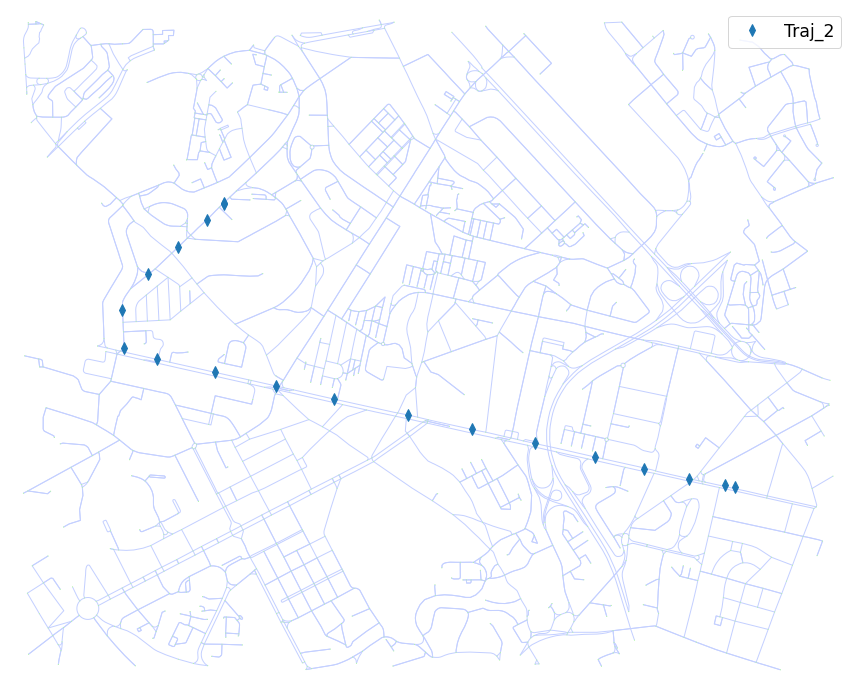

In [47]:
# plot graph using bounding box method
startTime = time.time()
marker    = ['o', 'd', 'p', '8', '<', 'v', '^', 'X', '>', 's']
fig, ax   = ox.plot_graph(G, figsize = (10, 10), bgcolor = '#FFFFFF', \
                          node_color = '#ACFF97', node_size = 1, \
                          edge_color = '#C4D0FF', show = False, close = False)

ax.plot(coords[i][0], coords[i][1], marker[i], ms = 8, label = 'Traj_{}'.format(i + 1))

plt.legend(fontsize = 'xx-large')
plt.tight_layout()
print("   Duration %s seconds" % (time.time() - startTime))

Detailed GPS plots for Trajectory 3

In [48]:
# extract 10 trajectories from the list of 1000 trajectories
xMax = yMax = 0
xMin = yMin = 0
bFirst      = True
i           = 2
tmpTraj = trajList[i]

for tmpCord in tmpTraj:
    tmpX = tmpCord[0]
    tmpY = tmpCord[1]
    xMax, yMax, xMin, yMin, bFirst = getMinMax(xMax, yMax, xMin, yMin, bFirst, tmpX, tmpY)

print('xMin:', xMin, ', yMin:', yMin, ', xMax:', xMax, ', yMax:', yMax)

xMin: -8.59653 , yMin: 41.140278 , xMax: -8.650395 , yMax: 41.154507


In [49]:
startTime       = time.time()
delta           = 0.01
bounds          = (xMax - delta / 2, xMin + delta / 2, yMin - delta * 0.7, yMax + delta * 0.7)
x1, x2, y1, y2  = bounds
boundaryPolygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)])
G               = ox.graph_from_polygon(boundaryPolygon, network_type = 'drive')
print("--- %s seconds ---" % (time.time() - startTime))

C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


--- 5.601993799209595 seconds ---


   Duration 1.2978689670562744 seconds


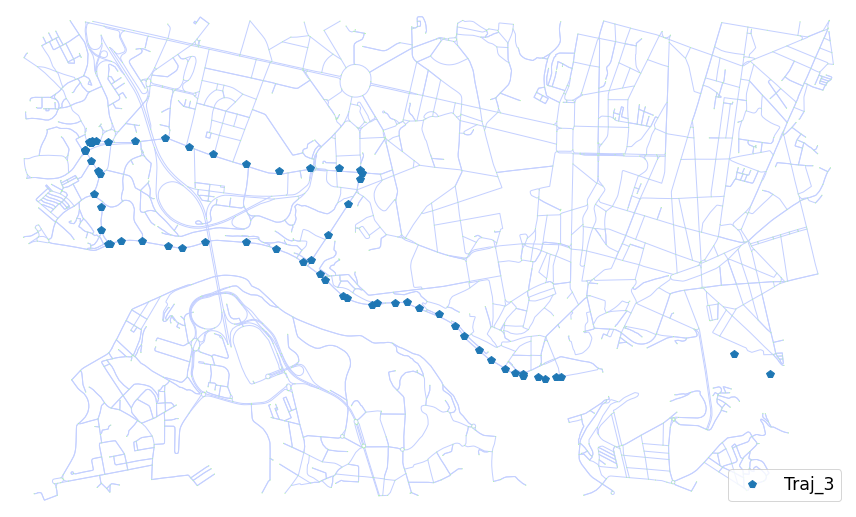

In [50]:
# plot graph using bounding box method
startTime = time.time()
marker    = ['o', 'd', 'p', '8', '<', 'v', '^', 'X', '>', 's']
fig, ax   = ox.plot_graph(G, figsize = (10, 10), bgcolor = '#FFFFFF', \
                          node_color = '#ACFF97', node_size = 1, \
                          edge_color = '#C4D0FF', show = False, close = False)

ax.plot(coords[i][0], coords[i][1], marker[i], ms = 8, label = 'Traj_{}'.format(i + 1))

plt.legend(fontsize = 'xx-large')
plt.tight_layout()
print("   Duration %s seconds" % (time.time() - startTime))

Detailed GPS plots for Trajectory 4

In [51]:
# extract 10 trajectories from the list of 1000 trajectories
xMax = yMax = 0
xMin = yMin = 0
bFirst      = True
i           = 3
tmpTraj = trajList[i]

for tmpCord in tmpTraj:
    tmpX = tmpCord[0]
    tmpY = tmpCord[1]
    xMax, yMax, xMin, yMin, bFirst = getMinMax(xMax, yMax, xMin, yMin, bFirst, tmpX, tmpY)

print('xMin:', xMin, ', yMin:', yMin, ', xMax:', xMax, ', yMax:', yMax)

xMin: -8.57466 , yMin: 41.142555 , xMax: -8.610849 , yMax: 41.15196


In [52]:
startTime       = time.time()
delta           = 0.01
bounds          = (xMax - delta / 2, xMin + delta / 2, yMin - delta * 0.7, yMax + delta * 0.7)
x1, x2, y1, y2  = bounds
boundaryPolygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)])
G               = ox.graph_from_polygon(boundaryPolygon, network_type = 'drive')
print("--- %s seconds ---" % (time.time() - startTime))

C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


--- 4.123276948928833 seconds ---


   Duration 0.802337646484375 seconds


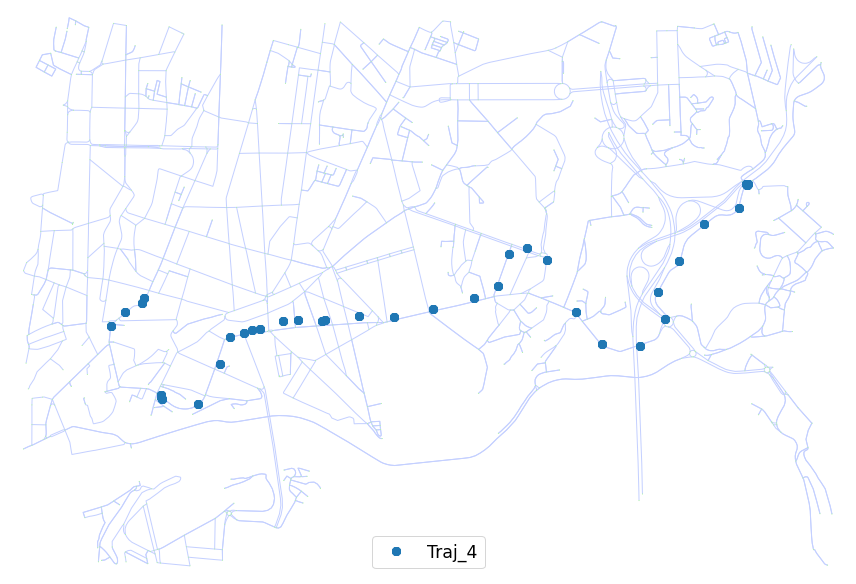

In [53]:
# plot graph using bounding box method
startTime = time.time()
marker    = ['o', 'd', 'p', '8', '<', 'v', '^', 'X', '>', 's']
fig, ax   = ox.plot_graph(G, figsize = (10, 10), bgcolor = '#FFFFFF', \
                          node_color = '#ACFF97', node_size = 1, \
                          edge_color = '#C4D0FF', show = False, close = False)

ax.plot(coords[i][0], coords[i][1], marker[i], ms = 8, label = 'Traj_{}'.format(i + 1))

plt.legend(fontsize = 'xx-large')
plt.tight_layout()
print("   Duration %s seconds" % (time.time() - startTime))

Detailed GPS plots for Trajectory 5

In [54]:
# extract 10 trajectories from the list of 1000 trajectories
xMax = yMax = 0
xMin = yMin = 0
bFirst      = True
i           = 4
tmpTraj = trajList[i]

for tmpCord in tmpTraj:
    tmpX = tmpCord[0]
    tmpY = tmpCord[1]
    xMax, yMax, xMin, yMin, bFirst = getMinMax(xMax, yMax, xMin, yMin, bFirst, tmpX, tmpY)

print('xMin:', xMin, ', yMin:', yMin, ', xMax:', xMax, ', yMax:', yMax)

xMin: -8.645949 , yMin: 41.171841 , xMax: -8.689086 , yMax: 41.180517


In [55]:
startTime       = time.time()
delta           = 0.01
bounds          = (xMax - delta / 2, xMin + delta / 2, yMin - delta * 0.7, yMax + delta * 0.7)
x1, x2, y1, y2  = bounds
boundaryPolygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)])
G               = ox.graph_from_polygon(boundaryPolygon, network_type = 'drive')
print("--- %s seconds ---" % (time.time() - startTime))

C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


--- 5.569364547729492 seconds ---


   Duration 0.9718453884124756 seconds


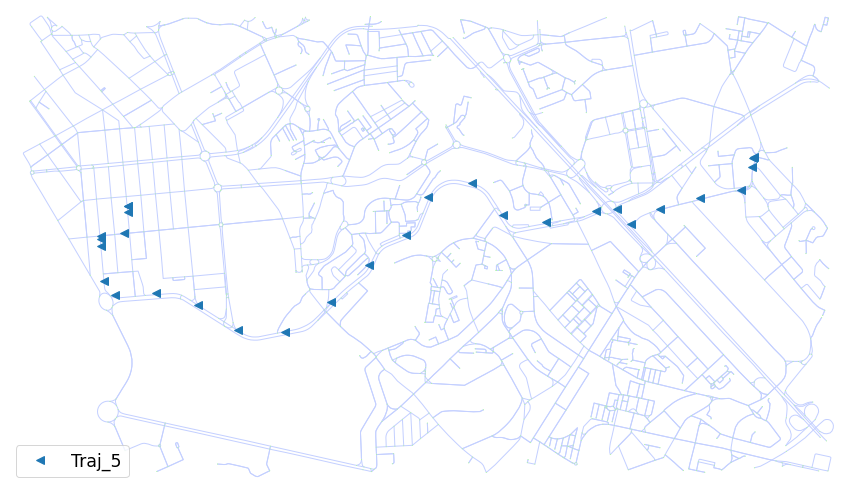

In [56]:
# plot graph using bounding box method
startTime = time.time()
marker    = ['o', 'd', 'p', '8', '<', 'v', '^', 'X', '>', 's']
fig, ax   = ox.plot_graph(G, figsize = (10, 10), bgcolor = '#FFFFFF', \
                          node_color = '#ACFF97', node_size = 1, \
                          edge_color = '#C4D0FF', show = False, close = False)

ax.plot(coords[i][0], coords[i][1], marker[i], ms = 8, label = 'Traj_{}'.format(i + 1))

plt.legend(fontsize = 'xx-large')
plt.tight_layout()
print("   Duration %s seconds" % (time.time() - startTime))

Detailed GPS plots for Trajectory 6

In [57]:
# extract 10 trajectories from the list of 1000 trajectories
xMax = yMax = 0
xMin = yMin = 0
bFirst      = True
i           = 5
tmpTraj = trajList[i]

for tmpCord in tmpTraj:
    tmpX = tmpCord[0]
    tmpY = tmpCord[1]
    xMax, yMax, xMin, yMin, bFirst = getMinMax(xMax, yMax, xMin, yMin, bFirst, tmpX, tmpY)

print('xMin:', xMin, ', yMin:', yMin, ', xMax:', xMax, ', yMax:', yMax)

xMin: -8.577594 , yMin: 41.140008 , xMax: -8.615502 , yMax: 41.160717


In [58]:
startTime       = time.time()
delta           = 0.01
bounds          = (xMax - delta / 2, xMin + delta / 2, yMin - delta * 0.7, yMax + delta * 0.7)
x1, x2, y1, y2  = bounds
boundaryPolygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)])
G               = ox.graph_from_polygon(boundaryPolygon, network_type = 'drive')
print("--- %s seconds ---" % (time.time() - startTime))

C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


--- 5.419059991836548 seconds ---


   Duration 1.1191608905792236 seconds


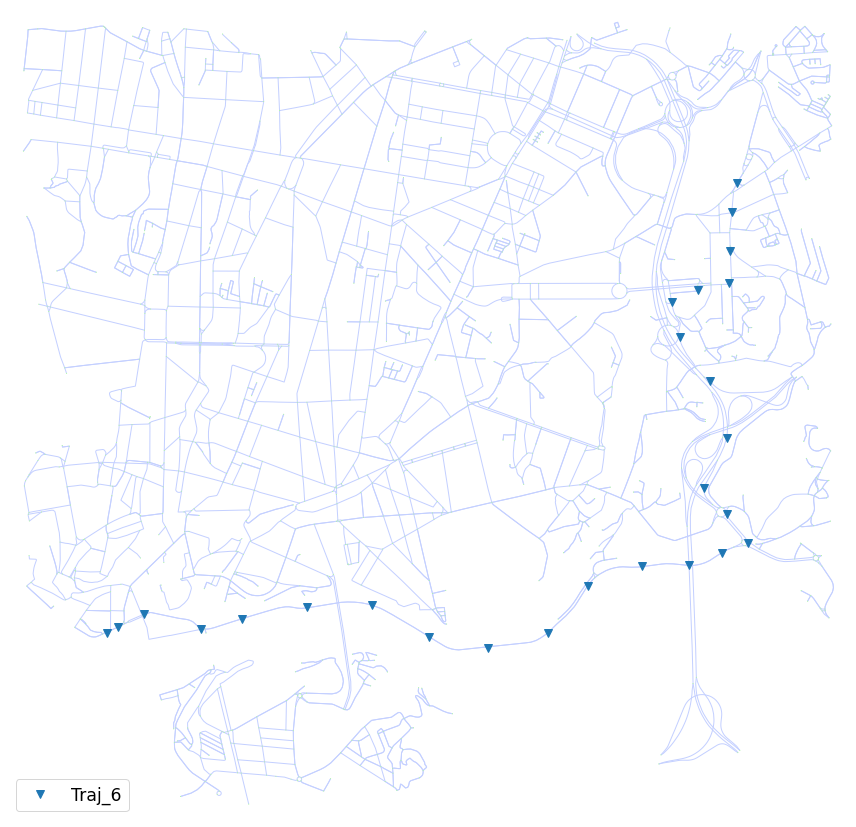

In [59]:
# plot graph using bounding box method
startTime = time.time()
marker    = ['o', 'd', 'p', '8', '<', 'v', '^', 'X', '>', 's']
fig, ax   = ox.plot_graph(G, figsize = (10, 10), bgcolor = '#FFFFFF', \
                          node_color = '#ACFF97', node_size = 1, \
                          edge_color = '#C4D0FF', show = False, close = False)

ax.plot(coords[i][0], coords[i][1], marker[i], ms = 8, label = 'Traj_{}'.format(i + 1))

plt.legend(fontsize = 'xx-large')
plt.tight_layout()
print("   Duration %s seconds" % (time.time() - startTime))

Detailed GPS plots for Trajectory 7

In [60]:
# extract 10 trajectories from the list of 1000 trajectories
xMax = yMax = 0
xMin = yMin = 0
bFirst      = True
i           = 6
tmpTraj = trajList[i]

for tmpCord in tmpTraj:
    tmpX = tmpCord[0]
    tmpY = tmpCord[1]
    xMax, yMax, xMin, yMin, bFirst = getMinMax(xMax, yMax, xMin, yMin, bFirst, tmpX, tmpY)

print('xMin:', xMin, ', yMin:', yMin, ', xMax:', xMax, ', yMax:', yMax)

xMin: -8.57952 , yMin: 41.142681 , xMax: -8.604945 , yMax: 41.15097


In [61]:
startTime       = time.time()
delta           = 0.01
bounds          = (xMax - delta / 2, xMin + delta / 2, yMin - delta * 0.7, yMax + delta * 0.7)
x1, x2, y1, y2  = bounds
boundaryPolygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)])
G               = ox.graph_from_polygon(boundaryPolygon, network_type = 'drive')
print("--- %s seconds ---" % (time.time() - startTime))

C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


--- 3.2771060466766357 seconds ---


C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


   Duration 0.5480034351348877 seconds


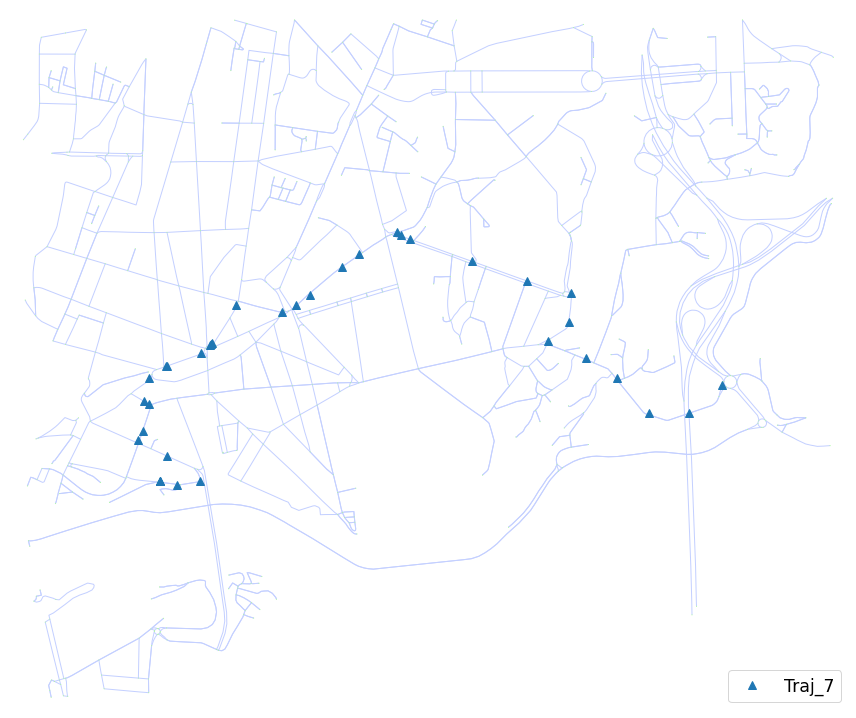

In [62]:
# plot graph using bounding box method
startTime = time.time()
marker    = ['o', 'd', 'p', '8', '<', 'v', '^', 'X', '>', 's']
fig, ax   = ox.plot_graph(G, figsize = (10, 10), bgcolor = '#FFFFFF', \
                          node_color = '#ACFF97', node_size = 1, \
                          edge_color = '#C4D0FF', show = False, close = False)

ax.plot(coords[i][0], coords[i][1], marker[i], ms = 8, label = 'Traj_{}'.format(i + 1))

plt.legend(fontsize = 'xx-large')
plt.tight_layout()
print("   Duration %s seconds" % (time.time() - startTime))

Detailed GPS plots for Trajectory 8

In [63]:
# extract 10 trajectories from the list of 1000 trajectories
xMax = yMax = 0
xMin = yMin = 0
bFirst      = True
i           = 7
tmpTraj = trajList[i]

for tmpCord in tmpTraj:
    tmpX = tmpCord[0]
    tmpY = tmpCord[1]
    xMax, yMax, xMin, yMin, bFirst = getMinMax(xMax, yMax, xMin, yMin, bFirst, tmpX, tmpY)

print('xMin:', xMin, ', yMin:', yMin, ', xMax:', xMax, ', yMax:', yMax)

xMin: -8.615142 , yMin: 41.144832 , xMax: -8.624736 , yMax: 41.161563


In [64]:
startTime       = time.time()
delta           = 0.01
bounds          = (xMax - delta / 2, xMin + delta / 2, yMin - delta * 0.7, yMax + delta * 0.7)
x1, x2, y1, y2  = bounds
boundaryPolygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)])
G               = ox.graph_from_polygon(boundaryPolygon, network_type = 'drive')
print("--- %s seconds ---" % (time.time() - startTime))

C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


--- 2.609147787094116 seconds ---


C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


   Duration 0.5504953861236572 seconds


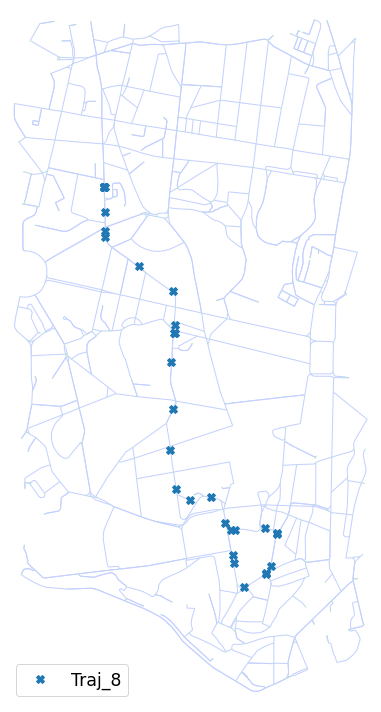

In [66]:
# plot graph using bounding box method
startTime = time.time()
marker    = ['o', 'd', 'p', '8', '<', 'v', '^', 'X', '>', 's']
fig, ax   = ox.plot_graph(G, figsize = (10, 10), bgcolor = '#FFFFFF', \
                          node_color = '#ACFF97', node_size = 1, \
                          edge_color = '#C4D0FF', show = False, close = False)

ax.plot(coords[i][0], coords[i][1], marker[i], ms = 8, label = 'Traj_{}'.format(i + 1))

plt.legend(fontsize = 'xx-large')
plt.tight_layout()
print("   Duration %s seconds" % (time.time() - startTime))

Detailed GPS plots for Trajectory 9

In [67]:
# extract 10 trajectories from the list of 1000 trajectories
xMax = yMax = 0
xMin = yMin = 0
bFirst      = True
i           = 8
tmpTraj = trajList[i]

for tmpCord in tmpTraj:
    tmpX = tmpCord[0]
    tmpY = tmpCord[1]
    xMax, yMax, xMin, yMin, bFirst = getMinMax(xMax, yMax, xMin, yMin, bFirst, tmpX, tmpY)

print('xMin:', xMin, ', yMin:', yMin, ', xMax:', xMax, ', yMax:', yMax)

xMin: -8.589402 , yMin: 41.140341 , xMax: -8.615844 , yMax: 41.163453


In [68]:
startTime       = time.time()
delta           = 0.01
bounds          = (xMax - delta / 2, xMin + delta / 2, yMin - delta * 0.7, yMax + delta * 0.7)
x1, x2, y1, y2  = bounds
boundaryPolygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)])
G               = ox.graph_from_polygon(boundaryPolygon, network_type = 'drive')
print("--- %s seconds ---" % (time.time() - startTime))

C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


--- 4.499222040176392 seconds ---


   Duration 0.9191081523895264 seconds


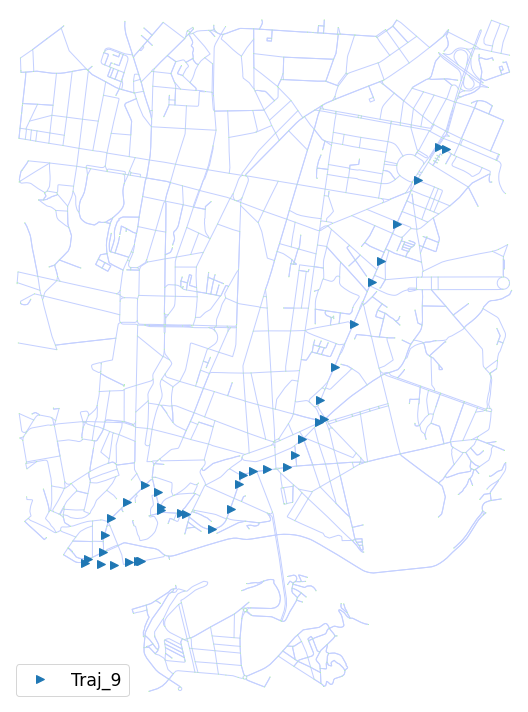

In [70]:
# plot graph using bounding box method
startTime = time.time()
marker    = ['o', 'd', 'p', '8', '<', 'v', '^', 'X', '>', 's']
fig, ax   = ox.plot_graph(G, figsize = (10, 10), bgcolor = '#FFFFFF', \
                          node_color = '#ACFF97', node_size = 1, \
                          edge_color = '#C4D0FF', show = False, close = False)

ax.plot(coords[i][0], coords[i][1], marker[i], ms = 8, label = 'Traj_{}'.format(i + 1))

plt.legend(fontsize = 'xx-large')
plt.tight_layout()
print("   Duration %s seconds" % (time.time() - startTime))

Detailed GPS plots for Trajectory 10

In [71]:
# extract 10 trajectories from the list of 1000 trajectories
xMax = yMax = 0
xMin = yMin = 0
bFirst      = True
i           = 9
tmpTraj = trajList[i]

for tmpCord in tmpTraj:
    tmpX = tmpCord[0]
    tmpY = tmpCord[1]
    xMax, yMax, xMin, yMin, bFirst = getMinMax(xMax, yMax, xMin, yMin, bFirst, tmpX, tmpY)

print('xMin:', xMin, ', yMin:', yMin, ', xMax:', xMax, ', yMax:', yMax)

xMin: -8.604594 , yMin: 41.134158 , xMax: -8.615907 , yMax: 41.14143


In [72]:
startTime       = time.time()
delta           = 0.01
bounds          = (xMax - delta / 2, xMin + delta / 2, yMin - delta * 0.7, yMax + delta * 0.7)
x1, x2, y1, y2  = bounds
boundaryPolygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)])
G               = ox.graph_from_polygon(boundaryPolygon, network_type = 'drive')
print("--- %s seconds ---" % (time.time() - startTime))

C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


--- 2.1299285888671875 seconds ---


C:\ProgramData\Anaconda3\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


   Duration 0.41266584396362305 seconds


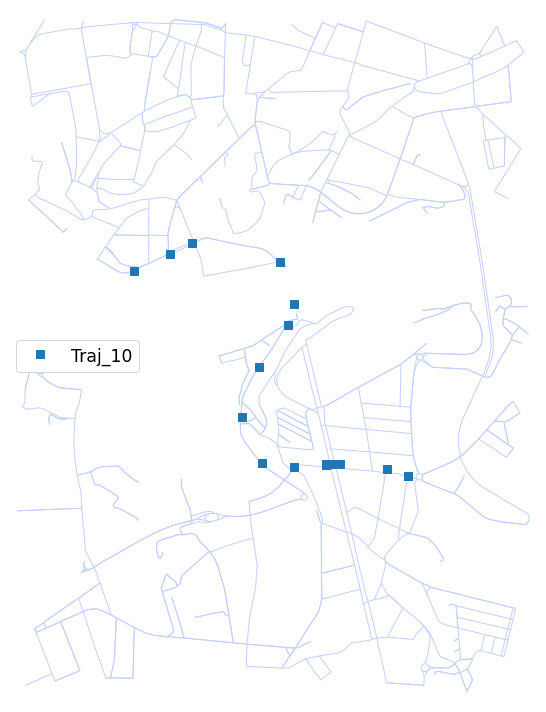

In [74]:
# plot graph using bounding box method
startTime = time.time()
marker    = ['o', 'd', 'p', '8', '<', 'v', '^', 'X', '>', 's']
fig, ax   = ox.plot_graph(G, figsize = (10, 10), bgcolor = '#FFFFFF', \
                          node_color = '#ACFF97', node_size = 1, \
                          edge_color = '#C4D0FF', show = False, close = False)

ax.plot(coords[i][0], coords[i][1], marker[i], ms = 8, label = 'Traj_{}'.format(i + 1))

plt.legend(fontsize = 'xx-large')
plt.tight_layout()
print("   Duration %s seconds" % (time.time() - startTime))